# Simulated Annealing

Let's revisit the shortest path problem discussed previously between the Equestrian Statue and the Bahen Centre, this time using simulated annealing.

Simulated annealing is a probabilistic method of optimizing functions. Named after the process of [annealing metals](https://en.wikipedia.org/wiki/Annealing_(materials_science)), simulated annealing is able to efficiently find a solution that is **close** to the global maximum. At its most basic level, simulated annealing chooses at each step whether to accept a neighbouring state or maintain the same state. While search algorithms like Hill Climbing and Beam Search always reject a neighbouring state with worse results, simulated annealing accepts those "worse" states probabilistically. 

<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>SIMULATED-ANNEALING</b>(<i>source</i>,<i>destination</i>, <i>schedule</i>, <i>num_iterations</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <i><font color="green">current</font></i> &larr; random <i>route</i> from <i>source</i> to <i>destination</i><br>
        for <i>num_iterations</i> do <br>
        <div style='padding-left:20px;'>
            <font color="orange">T</font></i> &larr; <i>schedule()</i> <br>
            <i><font color="purple">neighbours</font></i> &larr; <i><font color="green">current</font></i>.NEIGHBOURS<br>
            <i><font color="grey">next</font></i> &larr; randomly choose one state from <i><font color="purple">neighbours</font></i><br>
            <i>&Delta;E</i> &larr; <i><font color="grey">next</font></i>.COST - <i><font color="green">current</font></i>.COST<br>
            if <i>&Delta;E</i> < 0 then 
            <div style='padding-left:20px;'>
                <i><font color="green">current</font></i> &larr; <i><font color="grey">next</font></i><br>
            </div>
            else
            <div style='padding-left:20px;'>
                <i><font color="green">current</font></i> &larr; <i><font color="grey">next</font></i> only with probability of e<sup>-&Delta;E/T</sup>
            </div>
        </div>
    <br>
    <i>route</i> &larr; <i><font color="green">current</font></i><br>
    return <i>route</i>
    </div>

</div>
<br><br>

## Schedule
We also need to define an annealing schedule for the algorithm. In metallurgical annealing, the key to a successful annealing is the controlled increase of temperature of a metal to a specified temperature, holding it there for some time, and then cooling it in a controlled fashion. Similarly, the probability of accepting a non-negative &Delta;E changes as the algorithm progresses. At first, there may be a high probability that a clearly inferior neighbour may actually be accepted, as the algorithm considers a wider search space. As the algorithm progresses however, $T$ decreases according to a schedule until it reaches 0.

Below is an example of an annealing schedule:

In [1]:
import numpy as np

def exp_schedule(k=20, lam=0.005, limit=100):
    function = lambda t: (k * np.exp(-lam*t) if t <limit else 0)
    return function

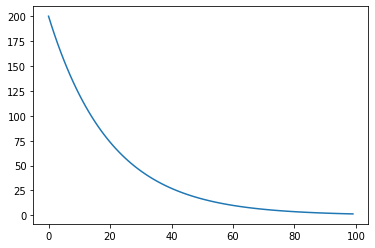

In [2]:
import matplotlib.pyplot as plt
schedule = exp_schedule(200,0.05,10000)
T = [schedule(k) for k in range(100)]
plt.plot(T)

## Example: Simulated annealing and the Traveling Salesman Problem

The [travelling salesman problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) is one of the most famous examples of optimization.

Let's generate a random graph of size 25. At this scale, looking for an exact solution to the TSP problem is nearly impossible (and computationally expensive).

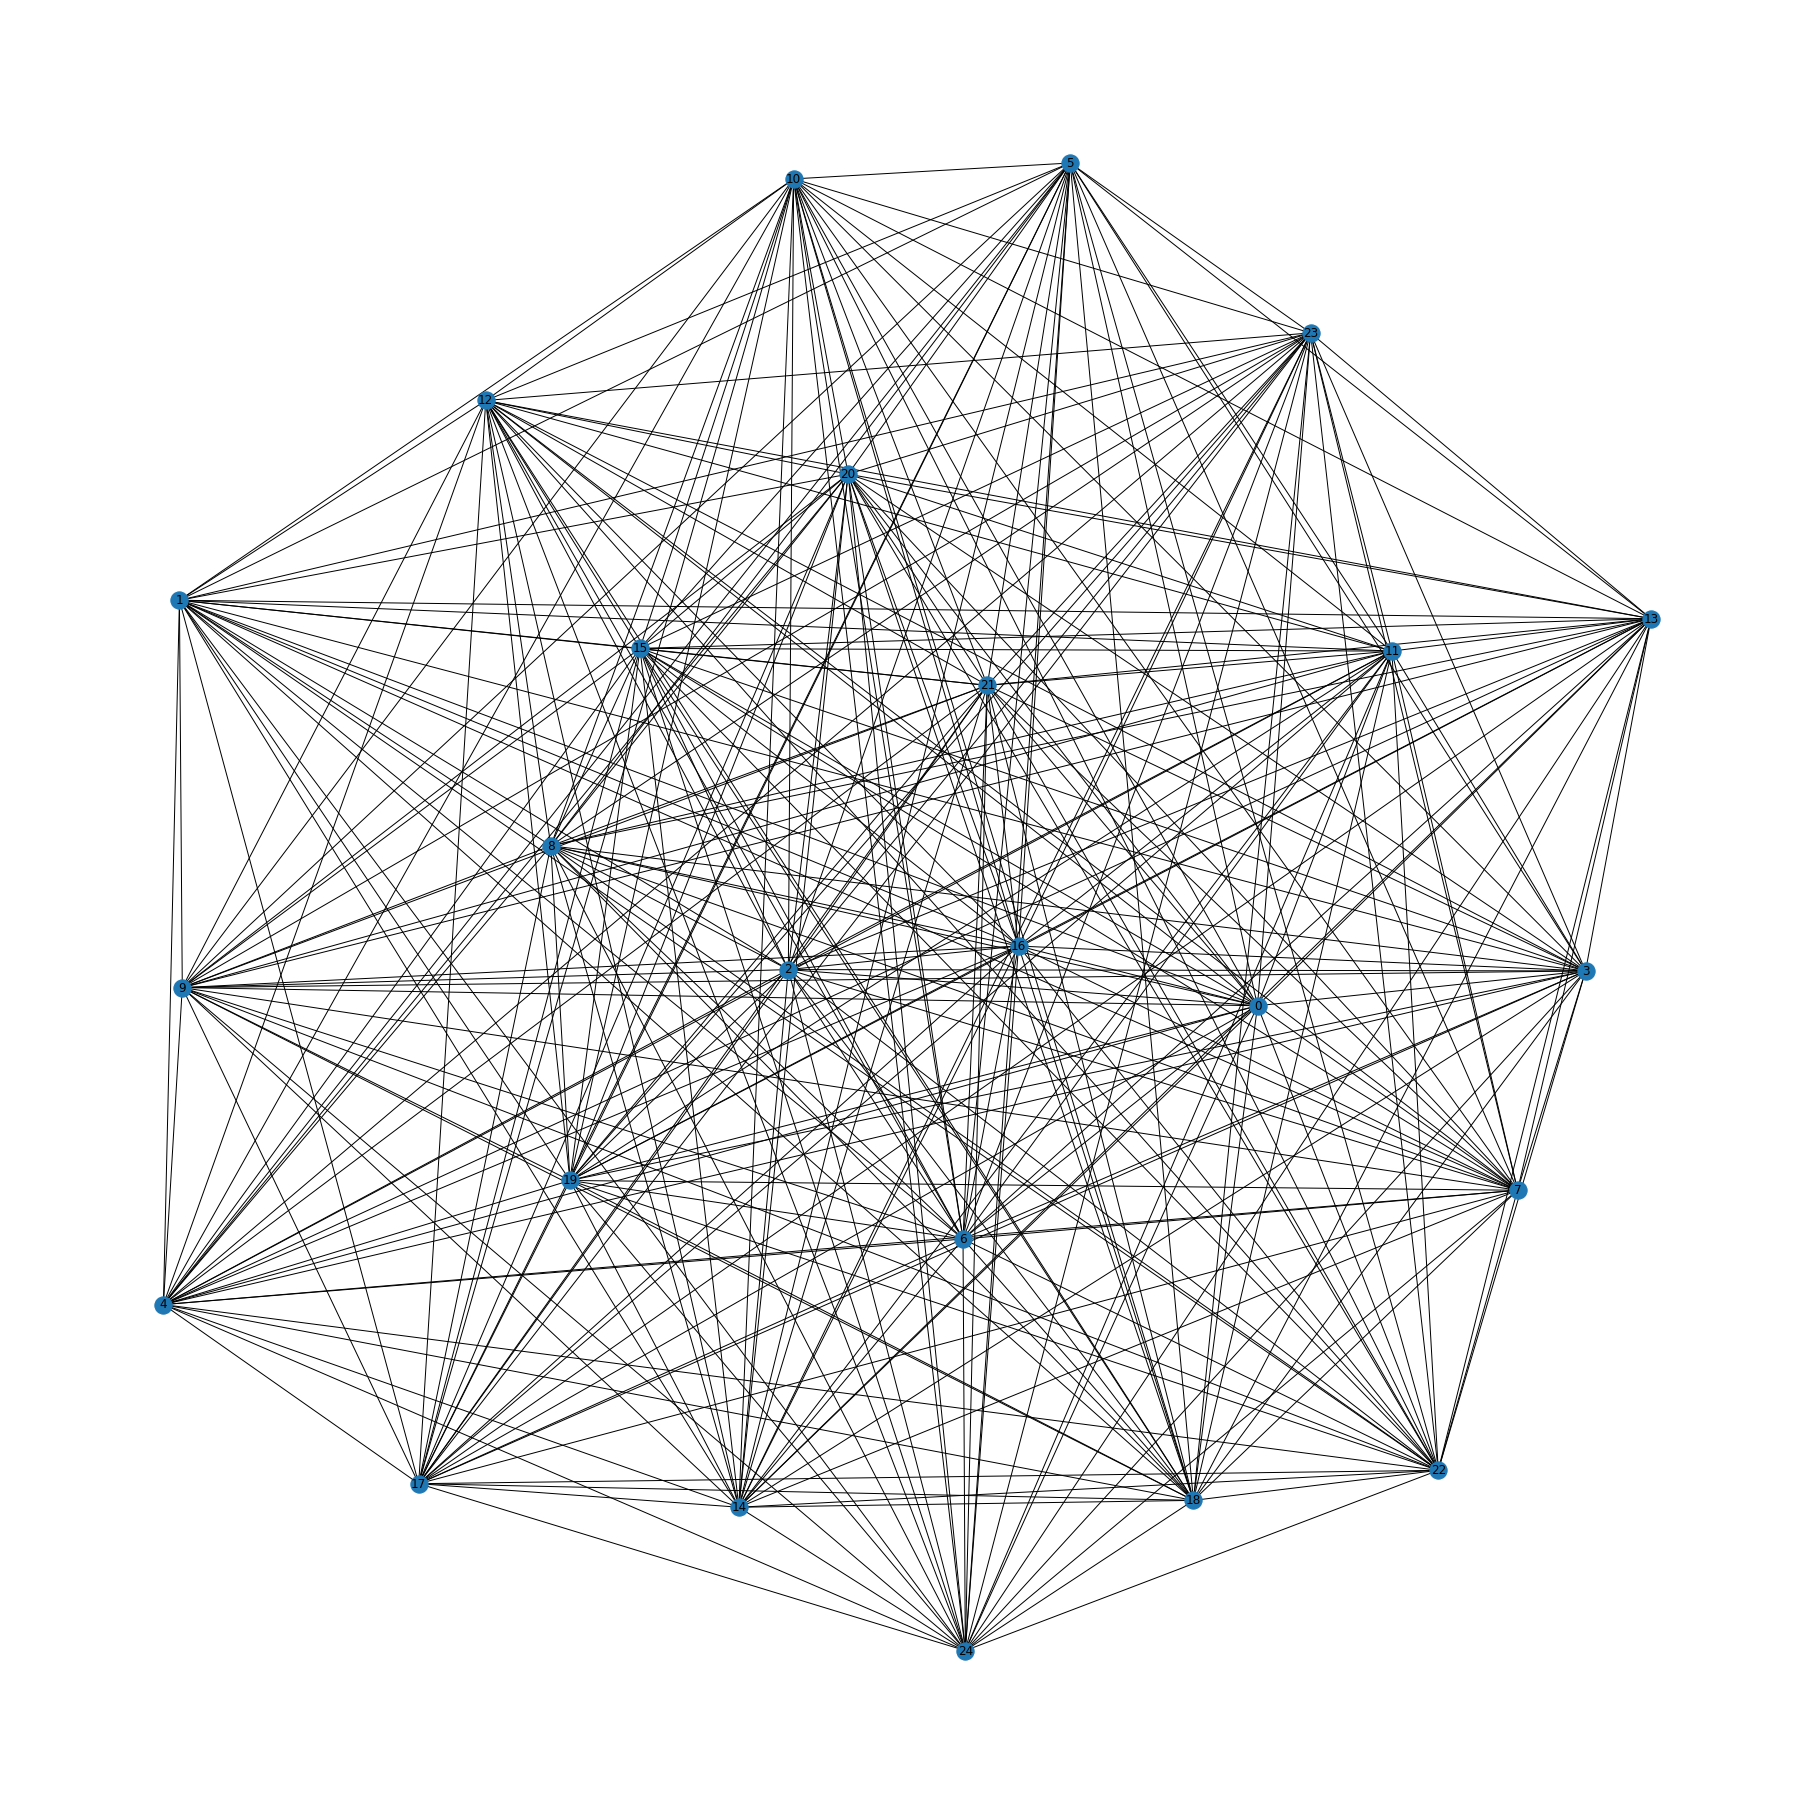

In [3]:
import networkx as nx
import random
from smart_mobility_utilities.common import probability
from tqdm.notebook import tqdm

longest_edge = 0
G = nx.complete_graph(25)
for (u, v) in G.edges():
    G.edges[u, v]["weight"] = random.randint(0, 10)
    if G.edges[u, v]["weight"] > longest_edge:
        longest_edge = G.edges[u, v]["weight"]
plt.figure(figsize=(25, 25))
nx.draw(G, with_labels=True)
plt.show()


In [4]:
# A little utility function that finds the cost of a tour
def cost_of_tour(G, tour):
    cost = 0
    for u,v in zip(tour, tour[1:]):
        cost += G[u][v]['weight']
    cost += G[len(tour) - 1][0]['weight']
    return cost

In [5]:
# A function to generate neighbours and select a route
def get_neighbours(G,tour):
    # generate 5 more paths to choose from
        neighbours = list()
        for _ in range(5):
            child = tour[:]
            i = random.randint(0, len(child) - 1)
            j = random.randint(0, len(child) - 1)
            child[i], child[j] = child[j], child[i]
            neighbours.append(child)
        
        return random.choice(neighbours)

In [6]:
def simulated_annealing(
    G, initial_solution, num_iter, schedule_function, neighbour_function, cost_function, use_tqdm=False
):
    
    current = initial_solution
    states = [cost_function(G,initial_solution)]
    if use_tqdm: pbar = tqdm(total=num_iter)
    for t in range(num_iter):
        if use_tqdm: pbar.update()
        T = schedule_function(t)
        next_choice = neighbour_function(G,current)
        current_cost = cost_function(G, current)
        next_cost = cost_function(G, next_choice)
        delta_e = next_cost - current_cost
        if delta_e < 0 or probability(np.exp(-1 * delta_e / T)):
            current = next_choice
        states.append(cost_function(G, current))

    return current, cost_function(G,current), states

Initial Solution: [15, 1, 24, 8, 18, 14, 3, 9, 16, 7, 10, 6, 13, 2, 11, 21, 0, 20, 17, 22, 5, 12, 23, 4, 19]
Initial Cost: 138
Best Solution :[21, 20, 7, 4, 0, 5, 3, 1, 6, 11, 9, 12, 24, 13, 16, 8, 19, 22, 10, 18, 17, 23, 14, 15, 2]
Best Cost: 34


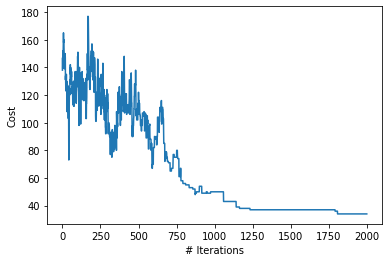

In [7]:
# Define the annealing schedule
num_of_iterations = 2000
schedule = exp_schedule(k=100, lam=0.005, limit=num_of_iterations)
schedules = [schedule(x) for x in range(2000)]

# Generate initial solution
initial_solution = [*G.nodes()]
random.shuffle(initial_solution)
print(f"Initial Solution: {initial_solution}")
print(f"Initial Cost: {cost_of_tour(G,initial_solution)}")
best_solution, best_cost, states = simulated_annealing(
    G, initial_solution, num_of_iterations, schedule, get_neighbours, cost_of_tour
)
print(f"Best Solution :{best_solution}")
print(f"Best Cost: {best_cost}")
plt.xlabel("# Iterations")
plt.ylabel("Cost")
plt.plot(states)
plt.show()


As you can see, the annealing schedule allows for more exploration at first, and then becomes more strict and generall only allows moving to a "better" solution.

## Example: SA Routing Problem

Here is an implementation of simulated annealing in `python` which generates a "shortest" path to solve our problem.

In [8]:
# Setup the Graph, origin, and destination
import osmnx
from smart_mobility_utilities.common import Node
from smart_mobility_utilities.viz import draw_route

reference = (43.661667, -79.395)
G = osmnx.graph_from_point(reference, dist=300, clean_periphery=True, simplify=True)
origin = Node(graph=G, osmid=55808290)
destination = Node(graph=G, osmid=389677909)

In [9]:
def get_neighbours_route(G, route):
    # Generate more paths to choose from
    neighbours = get_children(G,route,num_children=5)
    return random.choice(neighbours) 

In [10]:
from smart_mobility_utilities.common import randomized_search, cost
from smart_mobility_utilities.children import get_children

num_iterations = 1000
schedule = exp_schedule(1000, 0.005, num_iterations)
initial_solution = randomized_search(G, origin.osmid, destination.osmid)
print (f"Initial Solution: {initial_solution}")
print(f"Initial Cost: {cost(G,initial_solution)}")
best_solution, best_cost, states = simulated_annealing(
    G,
    initial_solution,
    num_iterations,
    schedule,
    get_neighbours_route,
    cost,
    use_tqdm=True
)


Initial Solution: [55808290, 304891685, 1721866234, 9270977970, 3179025274, 4953810914, 55808233, 299625330, 389677953, 2143488335, 389677947, 2143489692, 2480712846, 389678140, 389678139, 389678138, 3707407638, 6028561924, 5098988924, 389678131, 2557539841, 389678133, 389677909]
Initial Cost: 1014.285


  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
print(f"Best Solution: {best_solution}")
print(f"Best Cost: {best_cost}")
draw_route(G,best_solution)

Best Solution: [55808290, 304891685, 1721866234, 9270977970, 3179025274, 9270977966, 389678267, 24960090, 3108569783, 9270977968, 9270977981, 389678274, 389678273, 24959523, 50885177, 389677947, 2143489692, 2480712846, 389678140, 389678139, 389678138, 3707407638, 6028561924, 5098988924, 389678131, 2557539841, 389678133, 389677909]
Best Cost: 875.902


Map(center=[43.6609405, -79.3951948], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

We can also take a look at the different states that were traversed during the annealing:

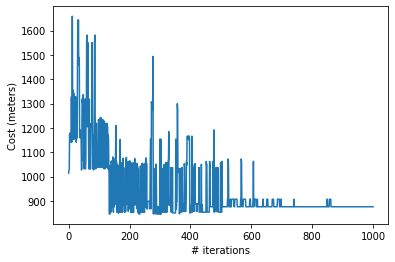

In [12]:
plt.xlabel("# iterations")
plt.ylabel("Cost (meters)")
plt.plot(states)
plt.show()

Unlike the strictly down-sloping graphs from beam search or hill-climbing, simulated annealing allows for the exploration of "worse" results, which broadens the search space.